# Model Training Speed Comparison Notebook

## 1. Imports and GPU Check

First, I installed and imported all required packages for model training.

In [ ]:
# Hide output of this cell and install packages
%%capture
!pip install fastcore fastai --upgrade
!pip3 install SemTorch

# Import packages
from fastai.vision.all import *
import numpy as np
import random
import os
import pytz
from datetime import datetime
from semtorch import get_segmentation_learner
from google.colab import drive
from IPython.display import Audio, display
from sklearn.model_selection import train_test_split

Then, I checked, which GPU had been allocated by Google Colab to ensure that training comparisons were performed using the same hardware.

In [ ]:
# Check, which GPU was allocated 
!nvidia-smi

Fri May 13 19:22:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    34W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
gpu_name = torch.cuda.get_device_name(0)

In [ ]:
gpu_name

'Tesla K80'

## 2. Define Required Functions and Set Parameters

### 2.1. Loss Functions

In [ ]:
# Custom loss functions
class CombinedLoss:
    '''Dice and Focal combined'''
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)


class Dual_Focal_loss(nn.Module):
    '''
    This loss is proposed in this paper: https://arxiv.org/abs/1909.11932
    '''

    def __init__(self, ignore_lb=255, eps=1e-5, reduction='mean'):
        super(Dual_Focal_loss, self).__init__()
        self.ignore_lb = ignore_lb
        self.eps = eps
        self.reduction = reduction
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, logits, label):
        ignore = label.data.cpu() == self.ignore_lb
        n_valid = (ignore == 0).sum()
        label = label.clone()
        label[ignore] = 0
        lb_one_hot = logits.data.clone().zero_().scatter_(1, label.unsqueeze(1), 1).detach()

        pred = torch.softmax(logits, dim=1)
        loss = -torch.log(self.eps + 1. - self.mse(pred, lb_one_hot)).sum(dim=1)
        loss[ignore] = 0
        if self.reduction == 'mean':
            loss = loss.sum() / n_valid
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'none':
            loss = loss
        return loss

### 2.2. Mount Google Drive, Set Path and Codes, and Define Required Functions

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Set path of root folder of images and masks
path = Path(f'/content/drive/MyDrive/Segmentation Data/aerial')

# Set codes
codes = ['Background', 'Building']

def n_codes(fnames, is_partial = True):
  '''Gather the codes from a list of `fnames`'''
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

def get_msk(fn, p2c):
  '''Grab a mask from a `filename` and adjust the pixels based on `p2c`'''
  pix2class = n_codes(lbl_names)
  fn = f'{path}/buildings_mask_tiles/2019_10cm_RGB_BE_67/{tile_type}/{fn.stem[:-3]}lbl{fn.suffix}'
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  return PILMask.create(msk)

def get_msk_augmented(fn, p2c):
  '''Grab a mask from a `filename` and adjust the pixels based on `pix2class`'''
  fn = str(fn).replace('img', 'lbl')
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  return PILMask.create(msk)

def get_y(o):
  return get_msk(o, p2c)

def get_y_augmented(o):
  return get_msk_augmented(o, p2c)

def batch_size(backbone, tile_size):
  '''Automatically set batch size depending on image size and architecture used'''
  if '512' in tile_size:
    if gpu_name == 'Tesla K80':
      batch_size_dict = {'resnet152': 1, 'resnet101': 1, 'resnet50': 1,
                        'resnet34': 8, 'resnet18': 9, 
                        'hrnet_w18': 27, 'hrnet_w30': 20, 'hrnet_w32': 20,
                        'hrnet_w48': 10}
  elif '256' in tile_size:
    batch_size_dict = {'resnet152': 2, 'resnet101': 2, 'resnet50': 2,
                       'resnet34': 11, 'resnet18': 10}
  return batch_size_dict[backbone]

def create_missing_folder(folder):
  '''Create missing folders'''
  if not os.path.exists(folder):
    os.makedirs(folder)

def timestamp():
  '''Timestamp experiments'''
  tz = pytz.timezone('Europe/Berlin')
  date = str(datetime.now(tz)).split(" ")
  date_time = f"{date[0]}_{date[1].split('.')[0][:5]}"
  return date_time

def model_notification():
  '''Create notification when model training is completed'''
  for i in range(5):
    display(Audio('https://www.soundjay.com/buttons/beep-03.wav', autoplay = True))
    time.sleep(2)

def get_tile_size(tile_type):
  if '512' in tile_type:
    tile_size = '512'
  elif '256' in tile_type:
    tile_size = '256'
  return tile_size

def check_fnames_lbls(tile_type, augmented = None):
  '''Get images and labels for dataloader and check whether their number is equal'''
  global fnames, lbl_names, path
  if augmented == False:
    fnames = get_image_files(f'{path}/image_tiles/2019_10cm_RGB_BE_67/{tile_type}')
    lbl_names = get_image_files(f'{path}/buildings_mask_tiles/2019_10cm_RGB_BE_67/{tile_type}')
  elif augmented == True:
    path = Path(f'/content/drive/MyDrive/Segmentation Data/aerial/augmented/8/{test_split}')
    fnames = get_image_files(path/'img')
    lbl_names = get_image_files(path/'lbl')
  if len(fnames) != len(lbl_names):
    print('ERROR: unequal number of image and mask tiles!')
  return fnames, lbl_names, path

def callbacks(model_dir, architecture, backbone, fit_type, timestamp):
  '''Log results in CSV, show progress, and stop early if dice coefficient doesn't improve for 10 epochs'''
  cbs = [CSVLogger(fname = f'{model_dir}/{architecture}_{backbone}_{fit_type}_{timestamp()}.csv', append = True),
        ShowGraphCallback(),
        EarlyStoppingCallback(monitor = 'dice', patience = 10, reset_on_fit = True)]
  return cbs

def check_dataset_balance(tile_type, augmented = None):
  '''Check, how balanced the dataset is'''
  global tile_size, p2c
  tile_size = get_tile_size(tile_type)

  # Check if there is a label for each image
  fnames, lbl_names, path = check_fnames_lbls(tile_type, augmented)

  # Get codes of masks
  p2c = n_codes(lbl_names)

  if augmented == False:
    label_func = get_y
  elif augmented == True:
    label_func = get_y_augmented

  # Create dataloader to check building pixels
  dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = label_func, bs = 64, codes = codes, seed = 2)

  targs = torch.zeros((0, 512, 512))
  for _, masks in dls[0]:
    targs = torch.cat((targs, masks.cpu()), dim = 0)

  total_pixels = targs.shape[1]**2
  percentages = torch.count_nonzero(targs, dim = (1,2)) / total_pixels
  plt.hist(percentages, bins = 20)
  plt.ylabel('Number of tiles')
  plt.xlabel('Ratio of pixels that are of class `building`')
  plt.gca().spines['top'].set_color('none')
  plt.gca().spines['right'].set_color('none')
  plt.show()
  print(f'Mean Percentage of Pixels Belonging to Buildings: {round(percentages.mean().item(), 3)}')
  return percentages

def u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = None, split = .2):
  '''Create list of files and masks, a dataloader, a model, callbacks, and train final model'''
  global tile_size, p2c, loss
  tile_size = get_tile_size(tile_type)
  # Create additional image augmentations
  tfms = [*aug_transforms(mult = 1.0, do_flip = True, flip_vert = True, max_rotate = 40.0,
                          min_zoom = 1.0, max_zoom = 1.4, max_warp = 0.4), Normalize.from_stats(*imagenet_stats)]

  # Check if there is a label for each image
  fnames, lbl_names, path = check_fnames_lbls(tile_type, augmented)

  # Get codes of masks
  p2c = n_codes(lbl_names)

  # Automatically set batch size depending on image size and backbone used
  bs = batch_size(backbone, tile_size)

  if augmented == False:
    # Create function to load images and masks
    dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = get_y, valid_pct = split,
                                                bs = bs, codes = codes, seed = 2, batch_tfms = tfms)
  elif augmented == True:
    # Create custom splitting function to exclude images in the 'valid' folder from training
    splitter = FuncSplitter(lambda fn: Path(fn).parent.name == 'valid')
    db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)), get_items = get_image_files,
               splitter = splitter, get_y = get_y_augmented, batch_tfms = tfms)
    dls = db.dataloaders(path/'img', bs = bs, valid_pct = split)
  
  print('loss_function: ', loss_function)
  if loss_function == 'Dual_Focal_loss':
    loss = Dual_Focal_loss()
  elif loss_function == 'CombinedLoss':
    loss = CombinedLoss()
  elif loss_function == 'DiceLoss':
    loss = DiceLoss()
  elif loss_function == 'FocalLoss':
    loss = FocalLoss()
  if loss_function == None:
    loss = None
    
  # Create model
  if backbone == 'resnet18':
    learn = unet_learner(dls, resnet18, n_out = 2, loss_func = loss, metrics = [Dice()] # Dice coefficient since dataset is imbalanced
                        ).to_fp16() # 16-bits floats, which take half the space in RAM
  elif backbone == 'resnet34':
    learn = unet_learner(dls, resnet34, n_out = 2, loss_func = loss, metrics = [Dice()]).to_fp16()
  elif backbone == 'resnet50':
    learn = unet_learner(dls, resnet50, n_out = 2, loss_func = loss, metrics = [Dice()]).to_fp16()
  elif backbone == 'resnet101':
    learn = unet_learner(dls, resnet101, n_out = 2, loss_func = loss, metrics = [Dice()]).to_fp16()
  elif backbone == 'vgg16_bn':
    learn = unet_learner(dls, vgg16_bn, n_out = 2, loss_func = loss, metrics = [Dice()]).to_fp16()

  learn.fit_one_cycle(epochs, cbs = callbacks(model_dir, architecture, backbone, fit_type, timestamp))
  return learn, dls

def seed():
  # Create Seed for Reproducibility
  number_of_the_seed = 2022
  random.seed(number_of_the_seed)
  set_seed(number_of_the_seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

def hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'HRNet', augmented = None, split = .2, bs = None):
  global tile_size, p2c, loss
  seed()

  tile_size = get_tile_size(tile_type)
  fnames, lbl_names, path = check_fnames_lbls(tile_type, augmented)

  if bs == None:
    bs = batch_size(backbone, tile_size)

  # Get codes of masks
  p2c = n_codes(lbl_names)

  if augmented == False:
    # Create function to load images and masks
    dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = get_y, bs = bs, codes = codes, seed = 2022,
                                                  batch_tfms = [Normalize.from_stats(*imagenet_stats)], valid_pct = split)
  elif augmented == True:
    splitter = FuncSplitter(lambda fn: Path(fn).parent.name == 'valid')
    db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)), get_items = get_image_files,
               splitter = splitter, get_y = get_y_augmented)
    dls = db.dataloaders(path/'img', bs = bs, valid_pct = split)


  if loss_function == 'CombinedLoss':
    loss = CombinedLoss()
  elif loss_function == 'DiceLoss':
    loss = DiceLoss()
  elif loss_function == None:
    loss = None

  learn = get_segmentation_learner(dls, number_classes = 2, segmentation_type = "Semantic Segmentation",
                                   architecture_name = "hrnet", backbone_name = backbone,
                                   model_dir = model_dir, metrics = [Dice()], splitter = trainable_params,
                                   pretrained = True, loss_func = loss).to_fp16()

  learn.fit_one_cycle(epochs, cbs = callbacks(model_dir, architecture, backbone, fit_type, timestamp))
  return learn, dls

# Set path to model directory to store model and callbacks
model_dir = f'{path}/models/Ferris'
create_missing_folder(model_dir)

def test_inference(dls, learn):
  # Testing inference speed of HRNET model
  input_dir = '/content/drive/MyDrive/Segmentation Data/aerial/inference/input/2019'
  # Time prediction on all tiles
  start_time_inf = datetime.now()
  preds = learn.get_preds(dl = dls.test_dl(get_image_files(input_dir)))
  end_time_inf = datetime.now()
  duration = end_time_inf - start_time_inf
  return duration

Mounted at /content/drive


## 3. Compare Training Speed on Full Manually Labelled Dataset (400 Tiles) (stopping after two epochs)

### 3.1. U-Net

In [ ]:
tile_type = '512_512 stride'
fit_type = 'FOC full manually labelled (400 tiles)'
epochs = 200

##### 3.1.1. ResNet 18 (NVIDIA Tesla K80) Batch Size: 9

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


loss_function:  DiceLoss


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,dice,time
0,9.472854,9.043554,0.022994,03:46
1,7.503656,6.841049,0.561787,02:49
2,6.177482,4.824903,0.819762,02:47


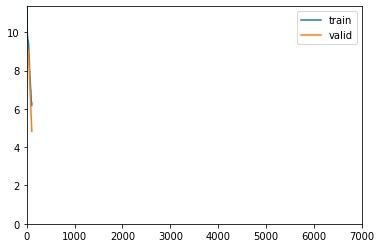

KeyboardInterrupt: ignored

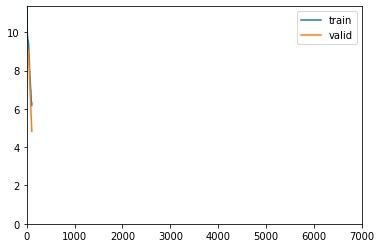

In [ ]:
loss_function = 'DiceLoss'
backbone = 'resnet18'

u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = False, split = .2)

##### 3.1.2. ResNet 34 (NVIDIA Tesla K80) Batch Size: 8

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


loss_function:  DiceLoss


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,dice,time
0,8.415899,8.237544,0.004894,04:27
1,8.839946,8.162341,0.031409,03:11
2,8.139875,5.792651,0.563390,03:12


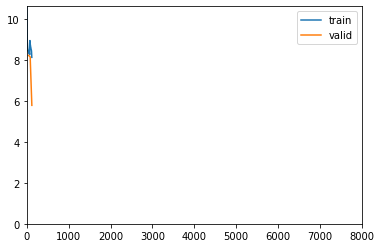

KeyboardInterrupt: ignored

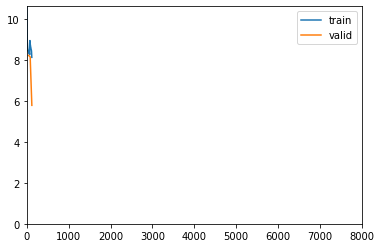

In [ ]:
loss_function = 'DiceLoss'
backbone = 'resnet34'

u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = False, split = .2)

### 3.2. HRNET

#### 3.2.1. HRNet W18 (NVIDIA Tesla K80) Batch Size: 27

In [ ]:
tile_type = '512_512 stride'
loss_function = None

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


100%|██████████| 83749/83749 [00:02<00:00, 35276.83KB/s]


epoch,train_loss,valid_loss,dice,time
0,0.517792,0.592892,0.575645,02:41
1,0.463459,0.607018,0.463777,02:22
2,0.411773,0.578415,0.524994,02:22


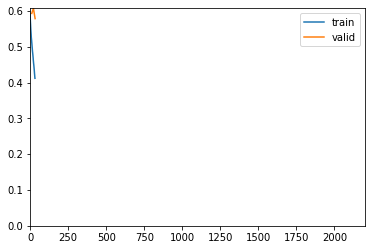

KeyboardInterrupt: ignored

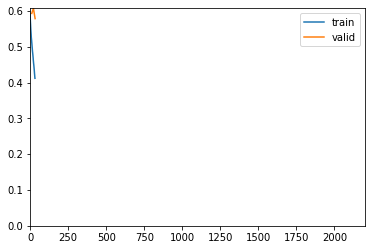

In [ ]:
backbone = 'hrnet_w18'
fit_type = f'FOC full manually labelled (400 tiles), backbone: {backbone}, loss: {loss_function}'
hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs = 200, augmented = False, split = .2)

#### 3.2.2. HRNet W48 (NVIDIA Tesla K80) Batch Size: 10

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


100%|██████████| 303363/303363 [00:12<00:00, 24741.30KB/s]


epoch,train_loss,valid_loss,dice,time
0,0.249087,0.714609,0.232877,06:58
1,0.136524,0.719057,0.463240,06:49
2,0.089023,0.586473,0.659942,06:48


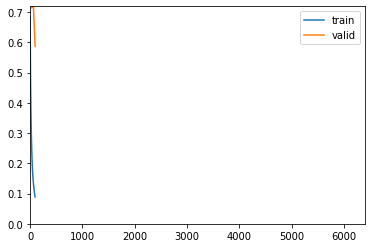

KeyboardInterrupt: ignored

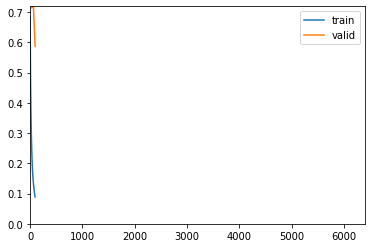

In [ ]:
backbone = 'hrnet_w48'
loss_function = None

fit_type = f'FOC full manually labelled (400 tiles), backbone: {backbone}, loss: {loss_function}'
hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs = 200, augmented = False, split = .2)